 # Transfer Learning with Tensorflow part 3

In [ ]:
!nvidia-smi

Sat Jan 27 14:50:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Create helper functions


In [1]:
 !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-29 14:25:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-29 14:25:58 (78.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import *

## 101 Food Classes: working with less data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-01-29 14:26:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   114MB/s    in 11s     

2024-01-29 14:26:15 (137 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent/")

There are 2 directories and 0 images in '101_food_classes_10_percent/'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 dir

In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode=('categorical'),
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

In [ ]:
# Create checkpoint callback
callback_path = "101_food_10_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = backbone(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool')(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pool (Globa  (None, 1280)              0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
initial_epoch = 5
history_0 = model_0.fit(train_data_all_10_percent,
                        epochs=initial_epoch,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 630ms/step - loss: 3.3693 - accuracy: 0.2746 - val_loss: 2.5631 - val_accuracy: 0.4425
Epoch 2/5
237/237 [==============================] - 105s 439ms/step - loss: 2.1984 - accuracy: 0.4944 - val_loss: 2.0710 - val_accuracy: 0.5024
Epoch 3/5
237/237 [==============================] - 90s 377ms/step - loss: 1.8241 - accuracy: 0.5624 - val_loss: 1.8978 - val_accuracy: 0.5291
Epoch 4/5
237/237 [==============================] - 82s 346ms/step - loss: 1.6110 - accuracy: 0.6081 - val_loss: 1.8158 - val_accuracy: 0.5344
Epoch 5/5
237/237 [==============================] - 74s 309ms/step - loss: 1.4492 - accuracy: 0.6444 - val_loss: 1.7955 - val_accuracy: 0.5339


In [ ]:
feature_extration_results = model_0.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.5837 - accuracy: 0.5815


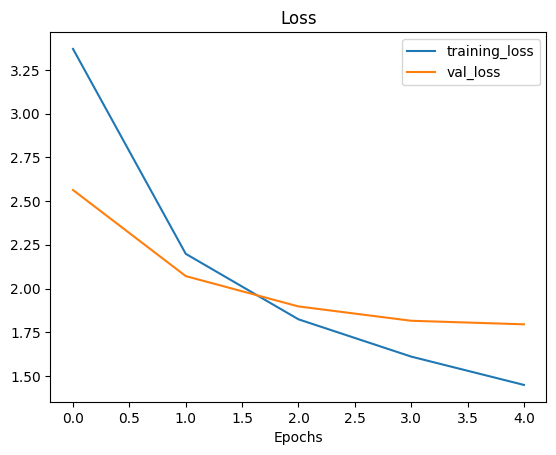

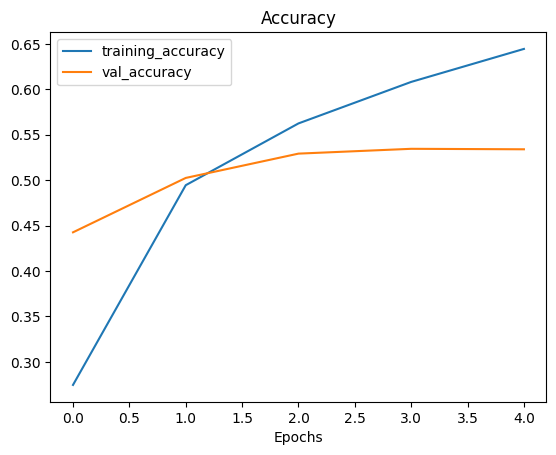

In [ ]:
plot_loss_curves(history_0)

# Fine-tuning

In [ ]:
backbone.trainable = True
for layer in backbone.layers[:-5]:
  layer.trainable = False

In [ ]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
for num, layer in enumerate(backbone.layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
fine_tune_epochs = initial_epoch + 5

history_fine_tune = model_0.fit(train_data_all_10_percent,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),
                                initial_epoch=history_0.epoch[-1],
                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 86s 324ms/step - loss: 1.2090 - accuracy: 0.6821 - val_loss: 1.7491 - val_accuracy: 0.5381
Epoch 6/10
237/237 [==============================] - 64s 269ms/step - loss: 1.0861 - accuracy: 0.7130 - val_loss: 1.7612 - val_accuracy: 0.5405
Epoch 7/10
237/237 [==============================] - 59s 248ms/step - loss: 1.0103 - accuracy: 0.7282 - val_loss: 1.7650 - val_accuracy: 0.5408
Epoch 8/10
237/237 [==============================] - 58s 243ms/step - loss: 0.9576 - accuracy: 0.7440 - val_loss: 1.7557 - val_accuracy: 0.5477
Epoch 9/10
237/237 [==============================] - 57s 239ms/step - loss: 0.8770 - accuracy: 0.7707 - val_loss: 1.7352 - val_accuracy: 0.5501
Epoch 10/10
237/237 [==============================] - 60s 251ms/step - loss: 0.8300 - accuracy: 0.7776 - val_loss: 1.7591 - val_accuracy: 0.5461


In [ ]:
fine_tune_results = model_0.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.4970 - accuracy: 0.6055


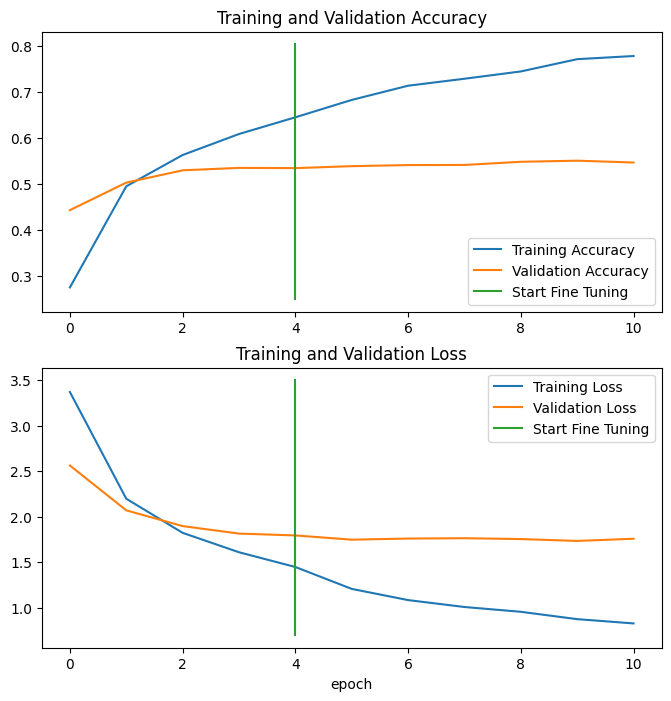

In [ ]:
compare_historys(original_history=history_0,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## saving and loading our model

In [ ]:
model_0.save("101_food_classes_saved_big_dog_model")

In [ ]:
loaded_model = tf.keras.models.load_model("101_food_classes_saved_big_dog_model/")

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.4970 - accuracy: 0.6055


[1.4969772100448608, 0.6054653525352478]

In [ ]:
fine_tune_results

[1.4969772100448608, 0.6054653525352478]

## Evaluating the performance of the model across all different classes


In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-01-29 14:26:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   146MB/s    in 0.3s    

2024-01-29 14:26:41 (146 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [8]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [9]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model/")

In [10]:
dowloaded_model_result = model.evaluate(test_data)

790/790 [==============================] - 65s 76ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

In [11]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 62s 77ms/step


In [12]:
len(preds_probs)

25250

In [13]:
# shape of our predictions
preds_probs.shape

(25250, 101)

In [14]:
# the first 10 predictions
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [15]:
# the first predictions
preds_probs[0], sum(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

In [16]:
print(f'Number of prediction probabilities for sample 0 : {len(preds_probs[0])}')
print(f'the class with the highest predicted probability by the model for sample 0 : {preds_probs[0].argmax()}')
print(f'class name : {test_data.class_names[preds_probs[0].argmax()]}')

Number of prediction probabilities for sample 0 : 101
the class with the highest predicted probability by the model for sample 0 : 52
class name : gyoza


In [17]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [18]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [19]:
y_test = []
for image, labels in test_data.unbatch():
  y_test.append(labels.numpy().argmax())

## Evaluating our model's predictions

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
score = accuracy_score(y_test, pred_classes)
score

0.6077623762376237

In [22]:
count = 0
for i in range(len(y_test)):
  if y_test[i] == pred_classes[i]:
    count += 1

count/len(y_test)

0.6077623762376237

## Making a confusion matrix

In [23]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [24]:
make_confusion_matrix(y_true=y_test,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Classification report


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=pred_classes))

### Visulatize classification report


In [26]:
report = classification_report(y_true=y_test, y_pred=pred_classes,output_dict=True)

In [27]:
f1_dict = {}

for key, value in report.items():
  if key == 'accuracy':
    break
  else:
    f1_dict[test_data.class_names[int(key)]] = value['f1-score']

In [28]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name":f1_dict.keys(),
                          "f1-score":f1_dict.values()}).sort_values('f1-score', ascending=False)

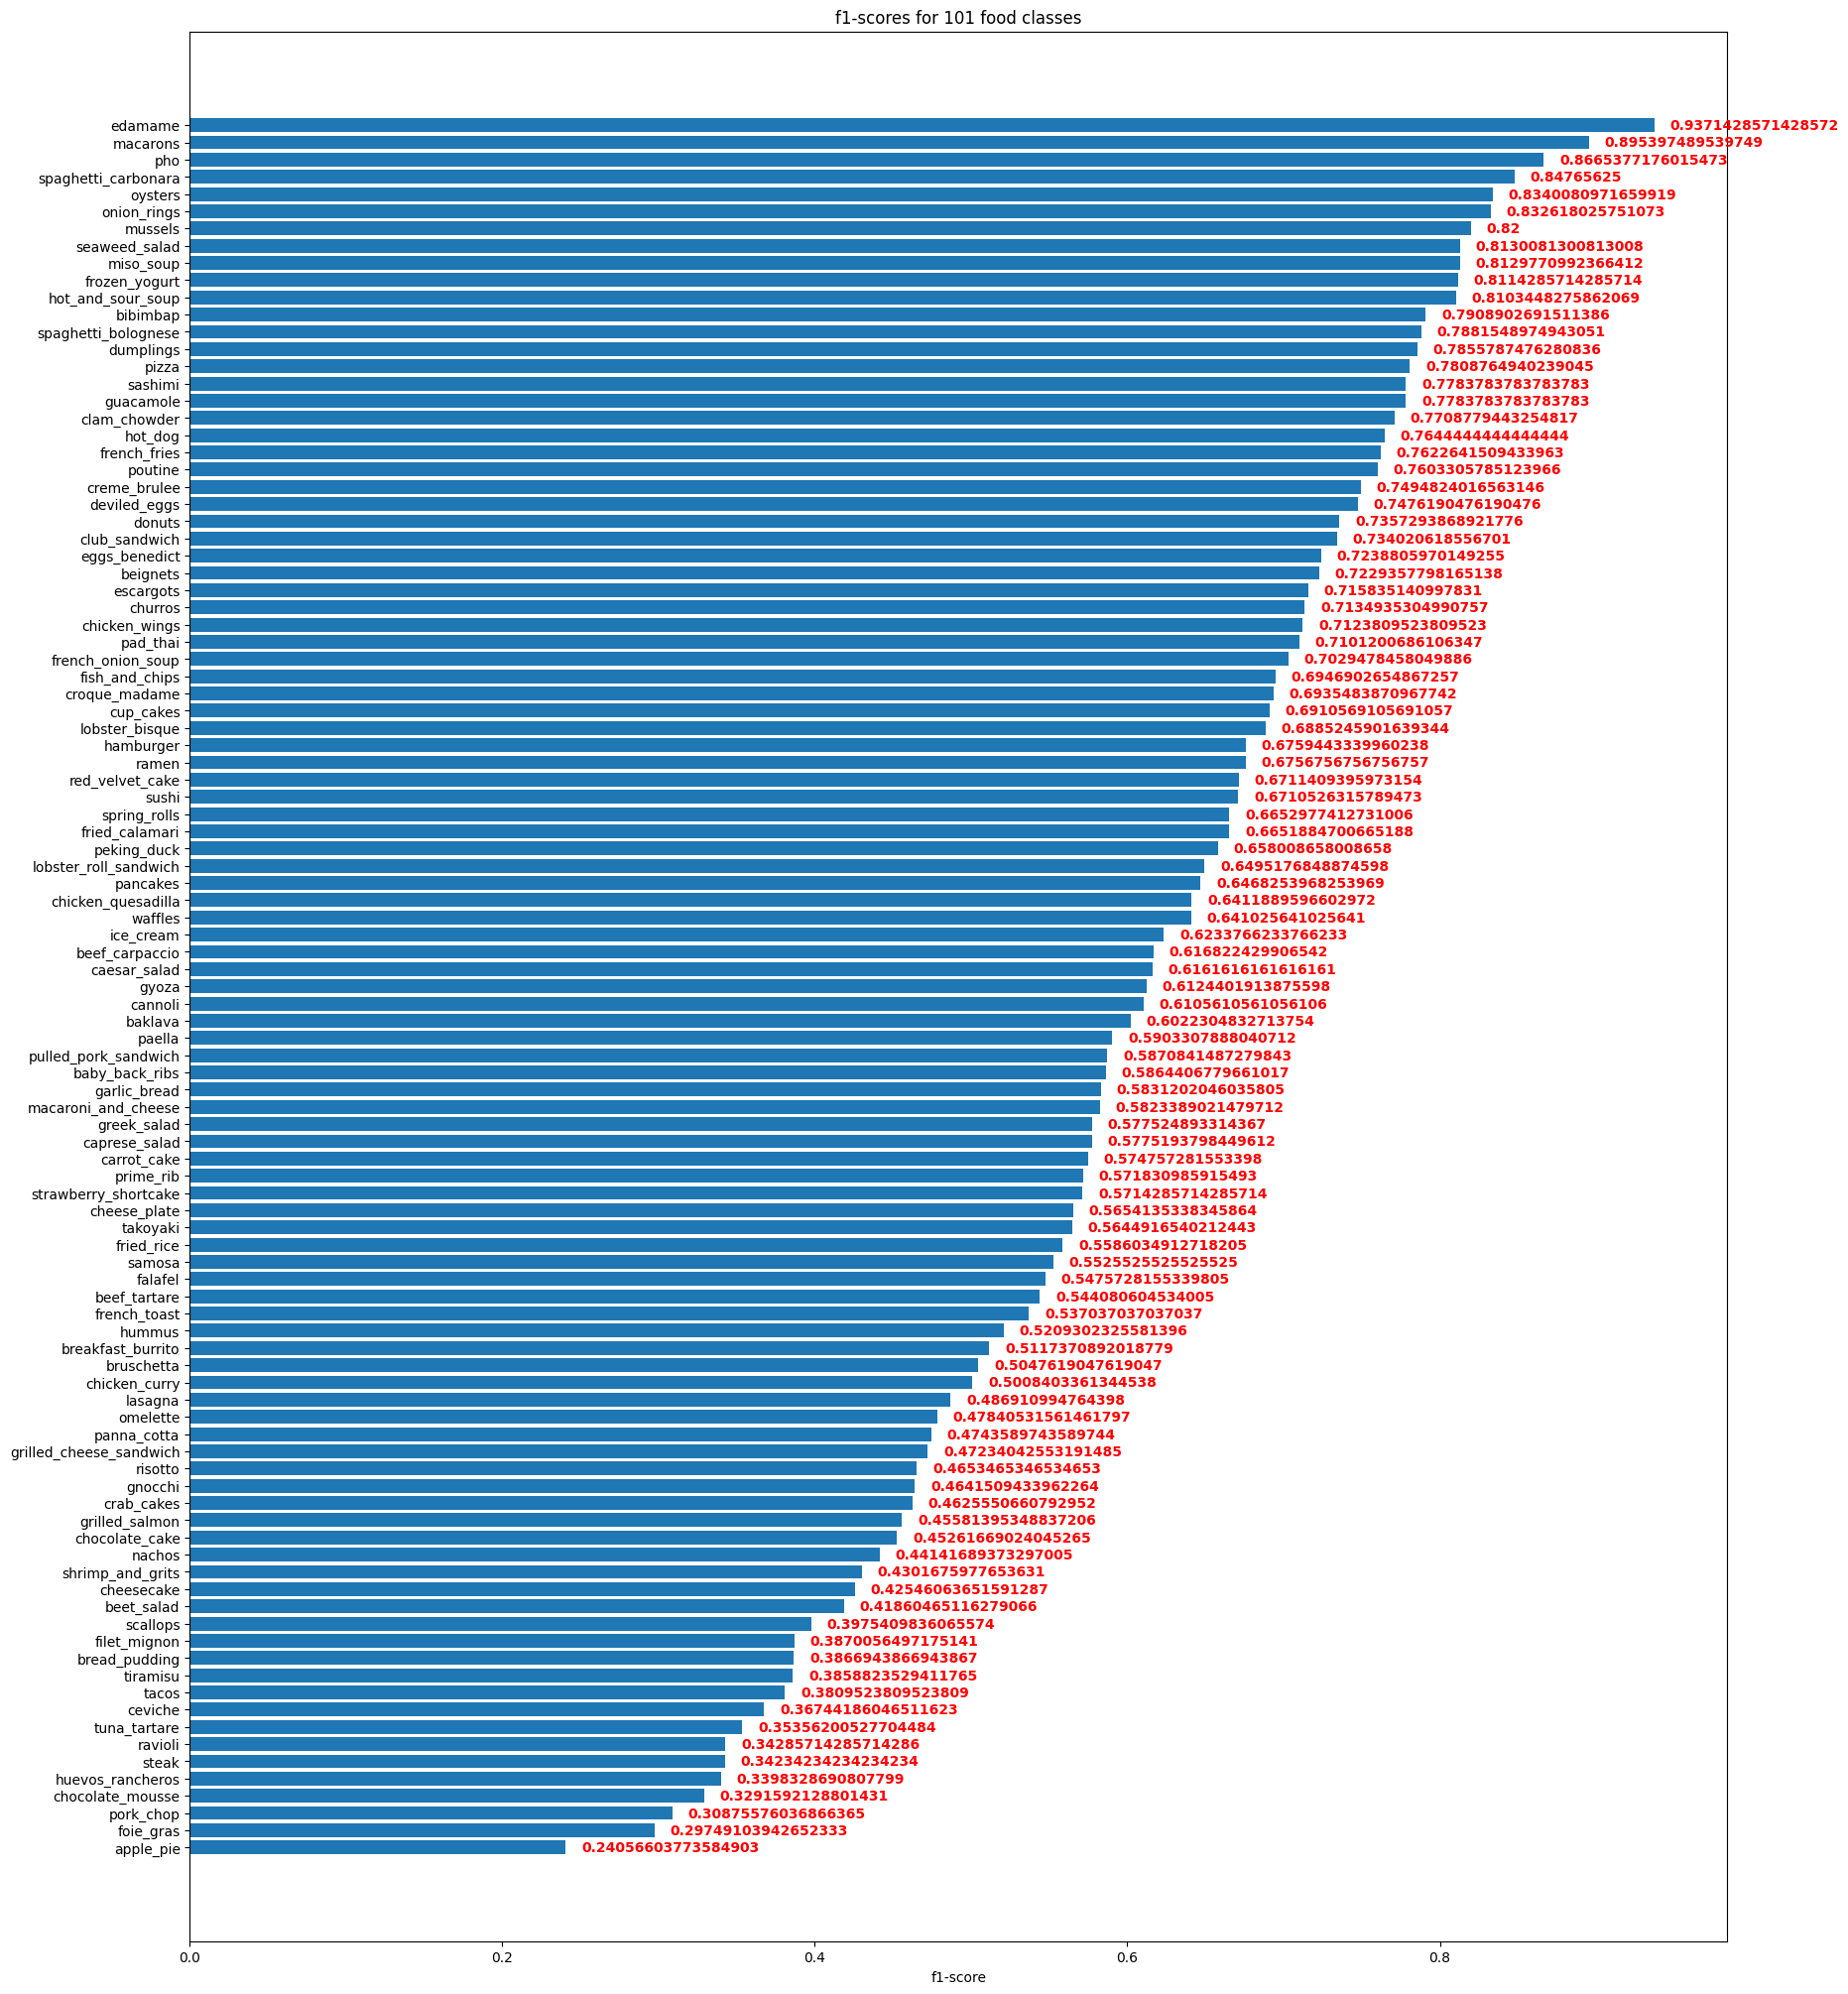

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_name'])
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for 101 food classes")
ax.invert_yaxis()

for i, v in enumerate(f1_scores['f1-score'].values):
  ax.text(v+0.01, i+0.25, str(v), color='red', fontweight='bold')

## Visualizing predictions on custom images

In [32]:
def load_and_pred_image(filename, img_shape=224, scale=True):
  """
        Reads in and image from filename, turns it into a tensorr and reshapedds into
        specified shape(img_shape, img_shape, color_channels=3).

        Args:
          filename (str): path to target image
          image_shape (int): height/width dimension of target image size
          scale (bool) : scale pixel values from 0-255 to 0-1 or not

        Returns:
          Image tensor of shape (img_shape, img_shape, 3)

  """
  img = tf.io.read_file(filename);
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img / 255.
  else:
    return img
